In [1]:
import torch
print('Torch verion:',torch.__version__)
print('cuda version', torch.version.cuda)

Torch verion: 1.8.1+cu102
cuda version 10.2


In [2]:
# TORCH = '1.8.1'
# CUDA = 'cu101'

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric 

In [3]:
## GRAPH CLASSIFICATION

In [4]:
# Import dataset
from torch_geometric.datasets import TUDataset

In [41]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[1]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.https://www.chrsmrrs.com/graphkerneldatasets/MUTAG.zipontains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_attr=[28, 4], edge_index=[2, 28], x=[13, 7], y=[1])
Number of nodes: 13
Number of edges: 28
Average node degree: 2.15
Contains self-loops: False
Is undirected: True


AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

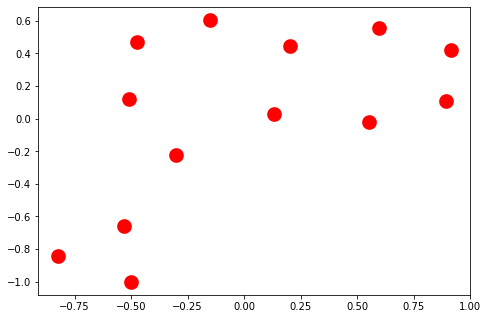

In [45]:
from torch_geometric.utils.convert import to_networkx

coragraph = to_networkx(data)

import matplotlib.pyplot as plt
nx.draw(coragraph, node_size=75,linewidths=6, with_labels = True, edge_color='b')
plt.show()

In [6]:
# Split data
torch.manual_seed(11)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print('Number of training graph:', len(train_dataset))
print('Number of testing graph:', len(test_dataset))

Number of training graph: 150
Number of testing graph: 38


In [7]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for step, data in enumerate(train_loader):
    print(f'Step {step+1}:')
    print('=====')
    print(f'Number of graphs in current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
=====
Number of graphs in current batch: 64
Batch(batch=[1162], edge_attr=[2554, 4], edge_index=[2, 2554], ptr=[65], x=[1162, 7], y=[64])

Step 2:
=====
Number of graphs in current batch: 64
Batch(batch=[1105], edge_attr=[2428, 4], edge_index=[2, 2428], ptr=[65], x=[1105, 7], y=[64])

Step 3:
=====
Number of graphs in current batch: 22
Batch(batch=[392], edge_attr=[868, 4], edge_index=[2, 868], ptr=[23], x=[392, 7], y=[22])



In [8]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(5)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index, batch):
        # Get node embeeding
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        # Readout alayer
        x = global_mean_pool(x, batch)
        
        # Out layer
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    
model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
for data in train_loader:
    print(data.edge_index.shape)
    print(data.x.shape)
    print(data.batch.shape)
    break

torch.Size([2, 2512])
torch.Size([1141, 7])
torch.Size([1141])


In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [61]:
torch.cuda.set_device(1)
print('Current cuda device ID:',torch.cuda.current_device())
print('Current cuda device name:', torch.cuda.get_device_name())

Current cuda device ID: 1
Current cuda device name: Tesla V100-PCIE-32GB


In [13]:
# Train/test
model = GCN(hidden_channels=64)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

def to_device(data, device):
    return data.to(device, non_blocking=True)

def train():
    model.train()
    for data in train_loader:
        a = to_device(data.x, device)
        b = to_device(data.edge_index, device)
        c = to_device(data.batch, device)
        d = to_device(data.y, device)
        
        out = model(a, b, c)
        loss = loss_func(out, d)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        a = to_device(data.x, device)
        b = to_device(data.edge_index, device)
        c = to_device(data.batch, device)
        d = to_device(data.y, device)
        
        out = model(a, b, c)
        pred = out.argmax(dim=1)
        correct += int((pred==d).sum())
    return correct/len(loader.dataset)

for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch:{epoch:03d}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')        
    

Epoch:001, Train acc: 0.6467, Test acc: 0.7368
Epoch:002, Train acc: 0.6467, Test acc: 0.7368
Epoch:003, Train acc: 0.6467, Test acc: 0.7368
Epoch:004, Train acc: 0.6467, Test acc: 0.7368
Epoch:005, Train acc: 0.6467, Test acc: 0.7368
Epoch:006, Train acc: 0.6533, Test acc: 0.7368
Epoch:007, Train acc: 0.7467, Test acc: 0.8421
Epoch:008, Train acc: 0.7267, Test acc: 0.8158
Epoch:009, Train acc: 0.7267, Test acc: 0.8421
Epoch:010, Train acc: 0.7333, Test acc: 0.8158
Epoch:011, Train acc: 0.7000, Test acc: 0.7895
Epoch:012, Train acc: 0.7200, Test acc: 0.8158
Epoch:013, Train acc: 0.7467, Test acc: 0.8158
Epoch:014, Train acc: 0.7533, Test acc: 0.8158
Epoch:015, Train acc: 0.7467, Test acc: 0.8158
Epoch:016, Train acc: 0.7067, Test acc: 0.8158
Epoch:017, Train acc: 0.7067, Test acc: 0.8158
Epoch:018, Train acc: 0.7467, Test acc: 0.8158
Epoch:019, Train acc: 0.7467, Test acc: 0.8158
Epoch:020, Train acc: 0.7067, Test acc: 0.8158
Epoch:021, Train acc: 0.7200, Test acc: 0.8158
Epoch:022, Tr

Epoch:179, Train acc: 0.8267, Test acc: 0.8158
Epoch:180, Train acc: 0.8267, Test acc: 0.8421
Epoch:181, Train acc: 0.8267, Test acc: 0.8421
Epoch:182, Train acc: 0.8200, Test acc: 0.8158
Epoch:183, Train acc: 0.8267, Test acc: 0.7632
Epoch:184, Train acc: 0.8467, Test acc: 0.8684
Epoch:185, Train acc: 0.8200, Test acc: 0.8158
Epoch:186, Train acc: 0.8467, Test acc: 0.8421
Epoch:187, Train acc: 0.8067, Test acc: 0.8421
Epoch:188, Train acc: 0.8400, Test acc: 0.8158
Epoch:189, Train acc: 0.8400, Test acc: 0.8158
Epoch:190, Train acc: 0.8200, Test acc: 0.8421
Epoch:191, Train acc: 0.8400, Test acc: 0.8684
Epoch:192, Train acc: 0.8200, Test acc: 0.8421
Epoch:193, Train acc: 0.8400, Test acc: 0.8684
Epoch:194, Train acc: 0.8000, Test acc: 0.8158
Epoch:195, Train acc: 0.8400, Test acc: 0.8684
Epoch:196, Train acc: 0.8533, Test acc: 0.8158
Epoch:197, Train acc: 0.8267, Test acc: 0.8421
Epoch:198, Train acc: 0.8267, Test acc: 0.8421
Epoch:199, Train acc: 0.8467, Test acc: 0.8421
Epoch:200, Tr

Epoch:359, Train acc: 0.8667, Test acc: 0.8421
Epoch:360, Train acc: 0.8733, Test acc: 0.8421
Epoch:361, Train acc: 0.8467, Test acc: 0.8158
Epoch:362, Train acc: 0.8733, Test acc: 0.8684
Epoch:363, Train acc: 0.8600, Test acc: 0.8158
Epoch:364, Train acc: 0.8533, Test acc: 0.8158
Epoch:365, Train acc: 0.8533, Test acc: 0.8684
Epoch:366, Train acc: 0.8533, Test acc: 0.8158
Epoch:367, Train acc: 0.8733, Test acc: 0.8421
Epoch:368, Train acc: 0.8467, Test acc: 0.8158
Epoch:369, Train acc: 0.8733, Test acc: 0.8421
Epoch:370, Train acc: 0.8600, Test acc: 0.8158
Epoch:371, Train acc: 0.8467, Test acc: 0.8158
Epoch:372, Train acc: 0.8667, Test acc: 0.8421
Epoch:373, Train acc: 0.8600, Test acc: 0.8684
Epoch:374, Train acc: 0.8600, Test acc: 0.8684
Epoch:375, Train acc: 0.8533, Test acc: 0.8158
Epoch:376, Train acc: 0.8267, Test acc: 0.8158
Epoch:377, Train acc: 0.8733, Test acc: 0.8158
Epoch:378, Train acc: 0.8733, Test acc: 0.8421
Epoch:379, Train acc: 0.8400, Test acc: 0.8158
Epoch:380, Tr

Epoch:539, Train acc: 0.8467, Test acc: 0.7895
Epoch:540, Train acc: 0.8733, Test acc: 0.8158
Epoch:541, Train acc: 0.8467, Test acc: 0.7895
Epoch:542, Train acc: 0.8733, Test acc: 0.8158
Epoch:543, Train acc: 0.8733, Test acc: 0.8158
Epoch:544, Train acc: 0.8733, Test acc: 0.7895
Epoch:545, Train acc: 0.8800, Test acc: 0.7895
Epoch:546, Train acc: 0.8467, Test acc: 0.7895
Epoch:547, Train acc: 0.8733, Test acc: 0.8158
Epoch:548, Train acc: 0.8733, Test acc: 0.8158
Epoch:549, Train acc: 0.8600, Test acc: 0.8158
Epoch:550, Train acc: 0.8667, Test acc: 0.8158
Epoch:551, Train acc: 0.8800, Test acc: 0.8158
Epoch:552, Train acc: 0.8733, Test acc: 0.8158
Epoch:553, Train acc: 0.8667, Test acc: 0.8158
Epoch:554, Train acc: 0.8733, Test acc: 0.8158
Epoch:555, Train acc: 0.8600, Test acc: 0.8158
Epoch:556, Train acc: 0.8733, Test acc: 0.8158
Epoch:557, Train acc: 0.8667, Test acc: 0.8158
Epoch:558, Train acc: 0.8800, Test acc: 0.7895
Epoch:559, Train acc: 0.8800, Test acc: 0.8158
Epoch:560, Tr

Epoch:716, Train acc: 0.8667, Test acc: 0.8158
Epoch:717, Train acc: 0.8867, Test acc: 0.7895
Epoch:718, Train acc: 0.8800, Test acc: 0.8158
Epoch:719, Train acc: 0.8733, Test acc: 0.8158
Epoch:720, Train acc: 0.8733, Test acc: 0.8158
Epoch:721, Train acc: 0.8667, Test acc: 0.7895
Epoch:722, Train acc: 0.8867, Test acc: 0.7895
Epoch:723, Train acc: 0.8733, Test acc: 0.7895
Epoch:724, Train acc: 0.8667, Test acc: 0.7895
Epoch:725, Train acc: 0.8800, Test acc: 0.7895
Epoch:726, Train acc: 0.8733, Test acc: 0.8158
Epoch:727, Train acc: 0.8667, Test acc: 0.8158
Epoch:728, Train acc: 0.8733, Test acc: 0.8158
Epoch:729, Train acc: 0.8667, Test acc: 0.8158
Epoch:730, Train acc: 0.8733, Test acc: 0.7895
Epoch:731, Train acc: 0.8733, Test acc: 0.7632
Epoch:732, Train acc: 0.8800, Test acc: 0.7895
Epoch:733, Train acc: 0.8800, Test acc: 0.7895
Epoch:734, Train acc: 0.8733, Test acc: 0.7895
Epoch:735, Train acc: 0.8800, Test acc: 0.7895
Epoch:736, Train acc: 0.8667, Test acc: 0.8421
Epoch:737, Tr

Epoch:895, Train acc: 0.8933, Test acc: 0.7632
Epoch:896, Train acc: 0.8467, Test acc: 0.7632
Epoch:897, Train acc: 0.8733, Test acc: 0.7895
Epoch:898, Train acc: 0.8667, Test acc: 0.8158
Epoch:899, Train acc: 0.8667, Test acc: 0.8158
Epoch:900, Train acc: 0.8667, Test acc: 0.7895
Epoch:901, Train acc: 0.8800, Test acc: 0.7895
Epoch:902, Train acc: 0.8800, Test acc: 0.7632
Epoch:903, Train acc: 0.8800, Test acc: 0.7632
Epoch:904, Train acc: 0.8800, Test acc: 0.7368
Epoch:905, Train acc: 0.8867, Test acc: 0.7632
Epoch:906, Train acc: 0.8600, Test acc: 0.7895
Epoch:907, Train acc: 0.8733, Test acc: 0.8158
Epoch:908, Train acc: 0.8867, Test acc: 0.7895
Epoch:909, Train acc: 0.8867, Test acc: 0.7895
Epoch:910, Train acc: 0.8800, Test acc: 0.7895
Epoch:911, Train acc: 0.8733, Test acc: 0.7895
Epoch:912, Train acc: 0.8800, Test acc: 0.7632
Epoch:913, Train acc: 0.8867, Test acc: 0.7895
Epoch:914, Train acc: 0.8733, Test acc: 0.7895
Epoch:915, Train acc: 0.8800, Test acc: 0.8158
Epoch:916, Tr

In [26]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [27]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8010
